<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/kalman/trend44.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cvxpy
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [2]:
#import all the necessary packages
import numpy as np
import yfinance as yf
from pandas.plotting import register_matplotlib_converters
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import cvxpy as cp
import seaborn as sns
sns.set()
register_matplotlib_converters()
import datetime
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

In [16]:
data = pd.read_csv('/content/vix.csv')

In [17]:
data['date']=data.time.apply(lambda d: datetime.datetime.fromtimestamp(int(d)).strftime('%Y-%m-%d'))
del data['time']
data['date']=pd.to_datetime(data['date'])
data= data.set_index('date')


In [19]:
data=data['10-10-2018':]

In [20]:
#@title Default title text
# Functions for our analysis - feel free to edit
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    return x, y

def regime_return(asset_pd, column_number, regime_col):
    """Computes returns of a list of regime columns identified by number"""
    asset_name = asset_pd.columns[column_number]
    regime = asset_pd[regime_col].values[:-1]
    asset_return = np.diff(asset_pd[asset_name],axis=0) / asset_pd[asset_name].values[:-1,:]
    ret_g, ret_c = asset_return[regime==1,:], asset_return[regime==-1,:]
    return asset_return, ret_g, ret_c

def regime_hist(asset_pd, column_number, regime_col):
    """Plots the asset regimes with regime column identified by number"""
    asset_return, ret_g, ret_c = regime_return(asset_pd, column_number, regime_col)
    plt.hist(ret_g, bins=20, color='green', label='Growth Regime',alpha=0.3)
    plt.hist(ret_c, bins=15, color='red', label='Contraction Regime',alpha=0.3)
    plt.xlabel('Monthly Return')
    plt.ylabel('Frequency')
    plt.legend(loc='upper left')
    plt.title('Regime Histogram of Asset: ' + asset_name)
    return ret_g, ret_c


def regime_plot(asset_data, column_num):
    ret_g1 = ret_g[:,column_num]
    ret_c1 = ret_c[:,column_num]
    plt.figure(figsize=(12,9))
    plt.plot(ecdf(ret_g1)[0], ecdf(ret_g1)[1], color='green',label='Normal Regime')
    plt.plot(ecdf(ret_c1)[0], ecdf(ret_c1)[1], color='red',label='Crash Regime')
    plt.xlabel('Monthly Return')
    plt.ylabel('Cumulative Probability')
    plt.legend(loc='upper left')
    plt.title('Cumulative Density of Asset: ' + asset_data.columns[column_num], fontsize=24)
    plt.show()
    
def trend_filtering(data,lambda_value):
    '''Runs trend-filtering algorithm to separate regimes.
        data: numpy array of total returns.'''

    n = np.size(data)
    x_ret = data.reshape(n)

    Dfull = np.diag([1]*n) - np.diag([1]*(n-1),1)
    D = Dfull[0:(n-1),]

    beta = cp.Variable(n)
    lambd = cp.Parameter(nonneg=True)

    def tf_obj(x,beta,lambd):
        return cp.norm(x-beta,2)**2 + lambd*cp.norm(cp.matmul(D, beta),1)

    problem = cp.Problem(cp.Minimize(tf_obj(x_ret, beta, lambd)))

    lambd.value = lambda_value
    problem.solve()

    return beta.value

def filter_plot(data,lambda_value,regime_num=0, TR_num=1):
    ret_sp = data.iloc[:,regime_num]
    sp500TR = data.values[:,TR_num]

    beta_value = trend_filtering(ret_sp.values,lambda_value)
    betas = pd.Series(beta_value,index=data.index)

    plt.figure(figsize=(12,9))
    plt.plot(ret_sp, alpha=0.4,label='Original Series')
    plt.plot(betas,label='Fitted Series')
    plt.xlabel('Year')
    plt.ylabel('Monthly Return (%)')
    plt.legend(loc='upper right')
    plt.show()
    
def regime_switch(betas,threshold=1e-5):
    '''returns list of starting points of each regime'''
    n = len(betas)
    init_points = [0]
    curr_reg = (betas[0]>threshold)
    for i in range(n):
        if (betas[i]>threshold) == (not curr_reg):
            curr_reg = not curr_reg
            init_points.append(i)
    init_points.append(n)
    return init_points

def plot_regime_color(dataset, regime_num=0, TR_num=1, lambda_value=16, log_TR = True):
    '''Plot of return series versus regime'''
    returns = dataset.iloc[:,regime_num]
    TR = dataset.iloc[:,TR_num]
    betas = trend_filtering(returns.values,lambda_value)
    regimelist = regime_switch(betas)
    curr_reg = np.sign(betas[0]-1e-5)
    y_max = np.max(TR) + 500
    #print('***** :',np.sign(betas))
    #print('current regime : ',curr_reg)
    if log_TR:
        fig, ax = plt.subplots()
        for i in range(len(regimelist)-1):
            if curr_reg == 1:
                ax.axhspan(0, y_max+500, xmin=regimelist[i]/regimelist[-1], xmax=regimelist[i+1]/regimelist[-1], 
                       facecolor='green', alpha=0.3)
            else:
                ax.axhspan(0, y_max+500, xmin=regimelist[i]/regimelist[-1], xmax=regimelist[i+1]/regimelist[-1], 
                       facecolor='red', alpha=0.5)
            curr_reg = -1 * curr_reg
        
        fig.set_size_inches(12,9)   
        plt.plot(TR, label='Total Return')
        plt.ylabel('SP500 Log-scale')
        plt.xlabel('Year')
        plt.yscale('log')
        plt.xlim([dataset.index[0], dataset.index[-1]])
        plt.ylim([9, 90])
        plt.yticks([9,10,12,15,18,22,25,30,40,70,90],[9,10,12,15,18,22,25,30,40,70,90])
        plt.title('Regime Plot of SP 500', fontsize=24)
        plt.show()
        
def geo_return(X, input_type='Return'):
    """Computes geometric return for each asset"""
    if input_type == 'Return':
        X_geo = 1+X
        y = np.cumprod(X_geo,axis=0)
        return (y[-1,:]) ** (1/X.shape[0]) - 1
    else:
        return (X[-1,:] / X[0,:]) ** (1/(X.shape[0]-1)) - 1

def portfolio_opt(mu, Q, r_bar):
    w = cp.Variable(mu.size)
    ret = mu.T*w 
    risk = cp.quad_form(w, Q)
    prob = cp.Problem(cp.Minimize(risk), 
                   [cp.sum(w) == 1, w >= 0, ret >= r_bar])
    prob.solve()
    return np.round_(w.value,decimals=3)



In [21]:
data['log_return'] = np.log1p(data.close.pct_change())*100

In [22]:
SP500_data=data[['log_return','close']][1:]

In [23]:
SP500_data.columns=['SP500','SP500TR']

/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1338: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


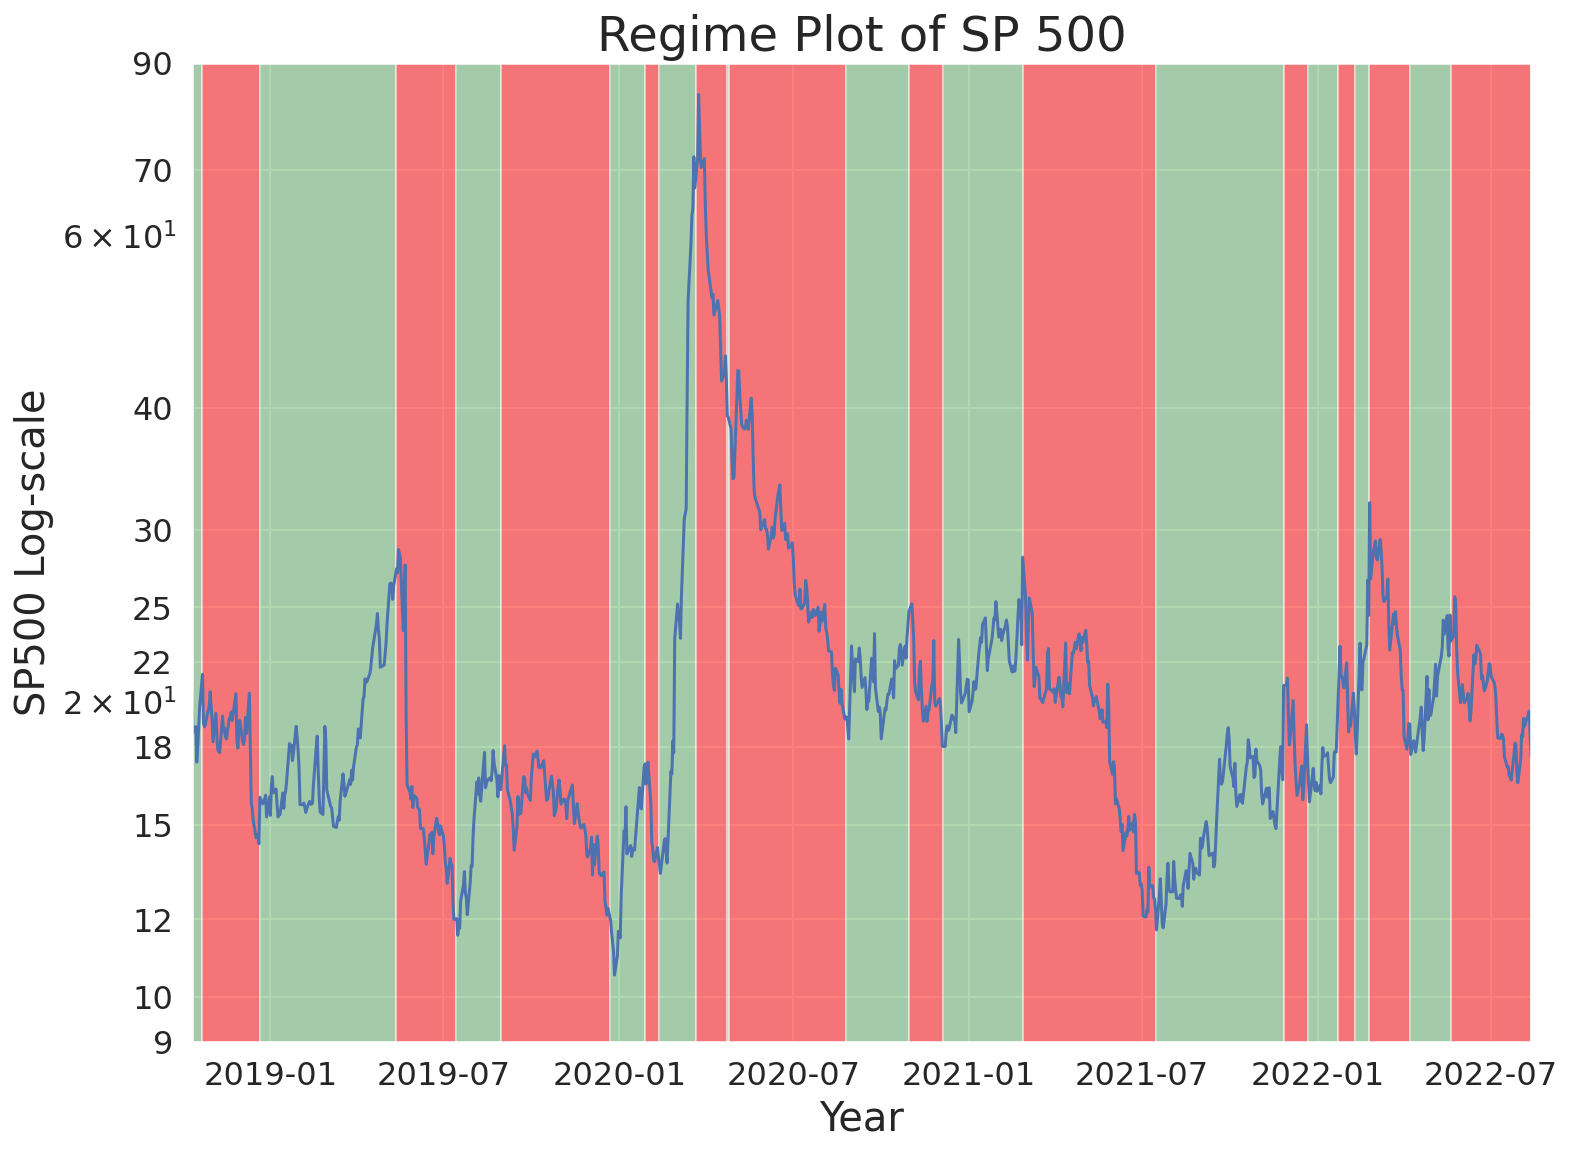

In [24]:
plot_regime_color(SP500_data, lambda_value=25)